In [5]:
#setup

import json
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import os
# %matplotlib inline
%matplotlib widget
plt.rcParams['figure.figsize'] = [10, 5]


In [6]:
jsonFileName = "mdpv2.json"
jsonDict = {}

epsilon = 1 # random vs policy actions while training
epsilons = [0,1]
convN = 10 # evaluates performance after convN episodes. Evaluates if converged after 10 performance evals
discount = 0.6 # short term vs long term reward
syncBackups = 1 # model backups between each sync
stochasticPolicy = True # sample from softmax instead of using argmax
envSeed = 42
alpha = 1 # step size
fedP = 2 # num agents
fedPs = [2, 4, 6, 8, 10]
syncBackupValues = [10000, 1000, 100, 10, 1]

# jupyter nbconvert --no-input --to pdf graphing.ipynb

print("epsilons " + str(epsilons))
print("convN " + str(convN))
print("dicount " + str(discount))
print("syncBackups " + str(syncBackups))
print("stochasticPolicy " + str(stochasticPolicy))
print("envSeed " + str(envSeed))
print("alpha " + str(alpha))
print("fedPs " + str(fedPs))

epsilons [0, 1]
convN 10
dicount 0.6
syncBackups 1
stochasticPolicy True
envSeed 42
alpha 1
fedPs [2, 4, 6, 8, 10]


In [7]:
if os.path.isfile(jsonFileName):
    jsonFile = open(jsonFileName)
    jsonDict = json.load(jsonFile)
    jsonFile.close()

# print(jsonDict.keys())



In [8]:
# read file
data = {}
for epsilon in epsilons:
    for syncBackups in syncBackupValues:
        alpha = 1

        epsSin = []
        epsFed = {}
        scoresSin = []
        scoresFed = {}
        scoresBell = []
        scoresStochSin = []
        scoresStochFed = {}
        scoresStochBell = []
        scoresRand = []
        diffsSin = []
        diffsFed = {}
        alphas = []
    
    
    
        for a in range(10):
            for fedP in fedPs:
                if not fedP in epsFed:
                    epsFed[fedP] = []
                    scoresFed[fedP] = []
                    diffsFed[fedP] = []
                    scoresStochFed[fedP] = []

                jsonDictKeyFed = str((convN, alpha, discount, epsilon, fedP, syncBackups, stochasticPolicy, envSeed))
                if jsonDictKeyFed in jsonDict:
#                     print(jsonDictKeyFed)
                    simsF, backupsF, episodesF, avgRF, rListF, diffsF, aggs, scoreF, scoreStochF, scoreBellF, scoreStochBellF, scoreRandF = jsonDict[jsonDictKeyFed]
                    epsFed[fedP].append(episodesF[0])
                    scoresFed[fedP].append(scoreF/100)
                    diffsFed[fedP].append(np.mean(diffsF[0][-10:]))
                    scoresStochFed[fedP].append(scoreStochF/100)

            jsonDictKeySin = str((convN, alpha, discount, epsilon, 1, -1, stochasticPolicy, envSeed))
            if jsonDictKeySin in jsonDict:
#                 print(jsonDictKeySin)
            # print(jsonDictKeySin)
                sims, backups, episodes, avgR, rList, diffs, score, scoreStoch, scoreBell, scoreStochBell, scoreRand = jsonDict[jsonDictKeySin]

                epsSin.append(episodes)
                scoresSin.append(score/100)
                scoresBell.append(scoreBell/100)
                scoresRand.append(scoreRand/100)
                scoresStochSin.append(scoreStoch / 100)
                scoresStochBell.append(scoreStochBell / 100)
                diffsSin.append(np.mean(diffs[-10:]))

                alphas.append(alpha)

                alpha /= 2
                
        data[str((convN, discount, epsilon, syncBackups, stochasticPolicy, envSeed))] = (epsSin,
                    epsFed,  
                    scoresSin,  
                    scoresFed,  
                    scoresBell,  
                    scoresStochSin,  
                    scoresStochFed,  
                    scoresStochBell,  
                    scoresRand,  
                    diffsSin,  
                    diffsFed,  
                    alphas)
                
# print("data")
# for key in data.keys():
#     print(key)

def loadData(convN=convN, discount=discount, epsilon=epsilon, syncBackups=syncBackups, stochasticPolicy=stochasticPolicy, envSeed=envSeed):
    global epsSin
    global epsFed
    global scoresSin
    global scoresFed
    global scoresBell
    global scoresStochSin
    global scoresStochFed
    global scoresStochBell
    global scoresRand 
    global diffsSin
    global diffsFed 
    global alphas
    (epsSin,
    epsFed,  
    scoresSin,  
    scoresFed,  
    scoresBell,  
    scoresStochSin,  
    scoresStochFed,  
    scoresStochBell,  
    scoresRand,  
    diffsSin,  
    diffsFed,  
    alphas) = data[str((convN, discount, epsilon, syncBackups, stochasticPolicy, envSeed))]

This graph is a comparison of learned models to the bellman model. A higher number of agents and smaller step size results in the lowest error to bellman. This trend appears linear on a log log plot for a variety of different numbers of agents.

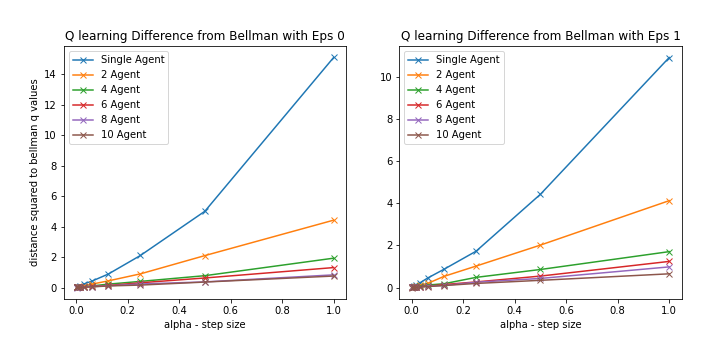

In [11]:
plt.clf()
for i in range(len(epsilons)):
    epsilon = epsilons[i]
    loadData(epsilon=epsilon, syncBackups=1)
    for placehold2 in [0]:
        plt.subplot(1, 2, i+1)
        plt.tight_layout(pad=3)
        plotName = "Q learning Difference from Bellman with Eps " + str(epsilon)
        plt.plot(alphas, np.array(diffsSin) ** 2, marker="x", label="Single Agent")
#         print(diffsFed)
        for fedP in fedPs:
#             print(fedP)
            plt.plot(alphas, np.array(diffsFed[fedP]) ** 2, marker="x", label=str(fedP) + " Agent")
        plt.legend()
        plt.xlabel("alpha - step size")
        if i == 0:
            plt.ylabel("distance squared to bellman q values")

        plt.title(plotName.replace("_", " "))
        # plt.ylim(0, 4)
        
#         plt.yscale('log', base=2)
#         plt.xscale('log', base=2)
plt.show()       

# plot lines divided by 1 agent

3d version of above plot by using number of agents as an additional axis instead of different series. This appears to be a plane on a log log log plot.

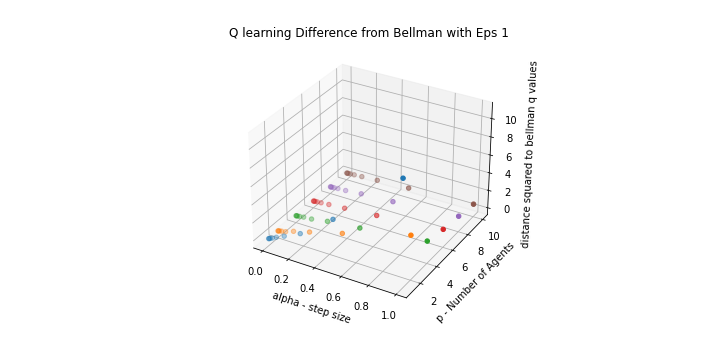

In [10]:
epsilon = 1
loadData(epsilon=epsilon, syncBackups=1)
plt.clf()
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D((alphas), ([1]*len(alphas)), np.array(diffsSin) ** 2, label="Single Agent")
for fedP in fedPs:
    ax.scatter3D((alphas), [fedP]*len(alphas), np.array(diffsFed[fedP]) ** 2, label=str(fedP) + " Agent")
ax.set_xlabel("alpha - step size")
ax.set_ylabel("p - Number of Agents")
ax.set_zlabel("distance squared to bellman q values")
plotName = "Q learning Difference from Bellman with Eps " + str(epsilon)
plt.title(plotName)
plt.show()  
# ax.legend()
# ax.set_xscale('log', base=2)
# ax.set_zscale('log', base=2)
# plt.show()

# invert to show inverse curve as linear

Test Reward when evaluated with a deterministic policy. Everything appears to be the same as bellman. This may present an issue with using reward to learn and get closer to bellman values for MDPs

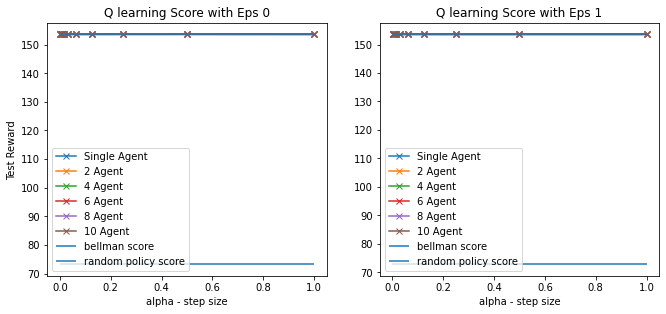

In [29]:
plt.clf()
for i in range(len(epsilons)):
    epsilon = epsilons[i]
    loadData(epsilon=epsilon, syncBackups=1)
    for placehold2 in [0]:
        plt.subplot(1, 2, i+1)
        plt.tight_layout(pad=3)
        plotName = "Q learning Score with Eps " + str(epsilon)
        plt.plot(alphas, scoresSin, marker="x", label="Single Agent")
        for fedP in fedPs:
            plt.plot(alphas, scoresFed[fedP], marker="x", label=str(fedP) + " Agent")
        plt.hlines(np.mean(scoresBell), 0, 1, label="bellman score")
        plt.hlines(np.mean(scoresRand), 0, 1, label="random policy score")
        plt.legend()
        plt.xlabel("alpha - step size")
        if i == 0:
            plt.ylabel("Test Reward")

        plt.title(plotName.replace("_", " "))
        # plt.ylim(0, 4)
        # plt.yscale('log', base=2)
        # plt.xscale('log', base=2)
plt.show()

<Figure size 720x360 with 0 Axes>

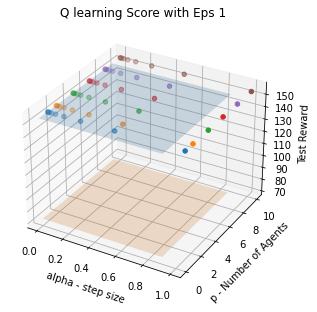

In [30]:
epsilon = 1
loadData(epsilon=epsilon, syncBackups=1)
plt.clf()
fig = plt.figure()
ax = plt.axes(projection='3d')
# print(scoresSin)
ax.scatter3D(alphas, [1]*len(alphas), scoresSin, label="Single Agent")
for fedP in fedPs:
    ax.scatter3D(alphas, [fedP]*len(alphas), scoresFed[fedP], label=str(fedP) + " Agent")
ax.set_xlabel("alpha - step size")
ax.set_ylabel("p - Number of Agents")
ax.set_zlabel("Test Reward")
ax.ticklabel_format(useOffset=False)
xx, yy = np.meshgrid(np.array(range(10))/10, range(10))
z = xx - xx + yy - yy
ax.plot_surface(xx, yy, z + np.mean(scoresBell), alpha=0.2, label="bellman score")
ax.plot_surface(xx, yy, z + np.mean(scoresRand), alpha=0.2, label="random policy score")
plt.title(plotName.replace("_", " "))
# ax.legend()
# ax.set_xscale('log', base=2)
# ax.set_zscale('log', base=2)
plt.show()

Test Reward when evaluated with a stochastic policy. This is the omly graph where epsilon 0 is noticably different than epsilon 1. Here the Q learning can get a higher score than the bellman Q values. Shows a rough increase in reward for more agents and smaller step sizes.

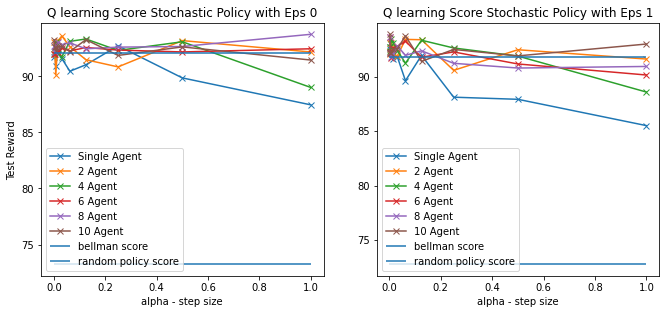

In [31]:
plt.clf()
for i in range(len(epsilons)):
    epsilon = epsilons[i]
    loadData(epsilon=epsilon, syncBackups=1)
    for placehold2 in [0]:
        plt.subplot(1, 2, i+1)
        plt.tight_layout(pad=3)
        plotName = "Q learning Score Stochastic Policy with Eps " + str(epsilon)
        plt.plot(alphas, scoresStochSin, marker="x", label="Single Agent")
        for fedP in fedPs:
            plt.plot(alphas, scoresStochFed[fedP], marker="x", label=str(fedP) + " Agent")
        plt.hlines(np.mean(scoresStochBell), 0, 1, label="bellman score")
        plt.hlines(np.mean(scoresRand), 0, 1, label="random policy score")
        plt.legend()
        plt.xlabel("alpha - step size")
        if i == 0:
            plt.ylabel("Test Reward")

        plt.title(plotName.replace("_", " "))
        # plt.ylim(0, 4)
        # plt.yscale('log', base=2, base=2)
        # plt.xscale('log', base=2, base=2)
plt.show()

<Figure size 720x360 with 0 Axes>

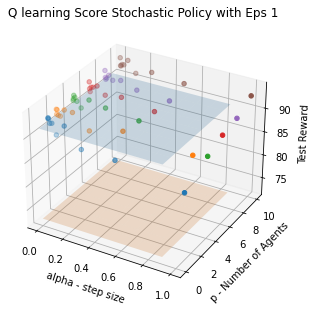

In [32]:
epsilon = 1
loadData(epsilon=epsilon, syncBackups=1)
plt.clf()
fig = plt.figure()
ax = plt.axes(projection='3d')
# print(scoresSin)
ax.scatter3D(alphas, [1]*len(alphas), scoresStochSin, label="Single Agent")
for fedP in fedPs:
    ax.scatter3D(alphas, [fedP]*len(alphas), scoresStochFed[fedP], label=str(fedP) + " Agent")
ax.set_xlabel("alpha - step size")
ax.set_ylabel("p - Number of Agents")
ax.set_zlabel("Test Reward")
ax.ticklabel_format(useOffset=False)
xx, yy = np.meshgrid(np.array(range(10))/10, range(10))
z = xx - xx + yy - yy
ax.plot_surface(xx, yy, z + np.mean(scoresStochBell), alpha=0.2, label="bellman score")
ax.plot_surface(xx, yy, z + np.mean(scoresRand), alpha=0.2, label="random policy score")
plt.title(plotName.replace("_", " "))
# ax.legend()
# ax.set_xscale('log', base=2)
# ax.set_zscale('log', base=2)
plt.show()

Convergence time, measured in model backups for a single agent (not all agents). This appears to show no speedup

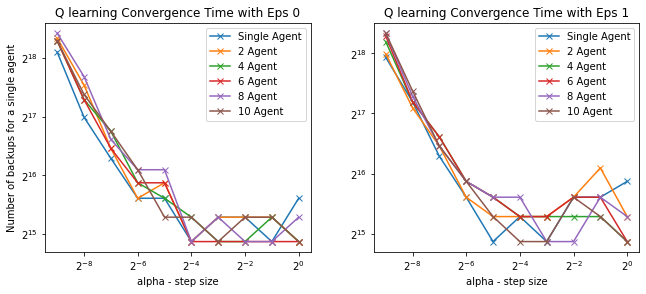

In [33]:
plt.clf()
for i in range(len(epsilons)):
    epsilon = epsilons[i]
    loadData(epsilon=epsilon, syncBackups=1)
    for placehold2 in [0]:
        plt.subplot(1, 2, i+1)
        plt.tight_layout(pad=4)
        plotName = "Q learning Convergence Time with Eps " + str(epsilon)
        plt.plot(alphas, np.array(epsSin) * 100, marker="x", label="Single Agent")
        for fedP in fedPs:
            plt.plot(alphas, np.array(epsFed[fedP]) * 100, marker="x", label=str(fedP) + " Agent")
        plt.legend()
        plt.xlabel("alpha - step size")
        if i == 0:
            plt.ylabel("Number of backups for a single agent")

        plt.title(plotName.replace("_", " "))
        # plt.ylim(0, 4)
        plt.yscale('log', base=2)
        plt.xscale('log', base=2)
plt.show()

<Figure size 720x360 with 0 Axes>

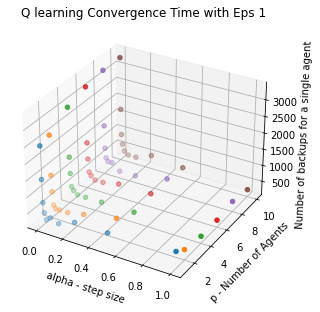

In [34]:
epsilon = 1
loadData(epsilon=epsilon, syncBackups=1)
plt.clf()
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(alphas, [1]*len(alphas), epsSin, label="Single Agent")
for fedP in fedPs:
    ax.scatter3D(alphas, [fedP]*len(alphas), epsFed[fedP], label=str(fedP) + " Agent")
ax.set_xlabel("alpha - step size")
ax.set_ylabel("p - Number of Agents")
ax.set_zlabel("Number of backups for a single agent")
ax.ticklabel_format(useOffset=False)
plt.title(plotName.replace("_", " "))
# ax.legend()
# ax.set_xscale('log', base=2)
# ax.set_zscale('log', base=2)
plt.show()

In [41]:
os.system("jupyter nbconvert --no-input --to pdf graphing.ipynb")

0

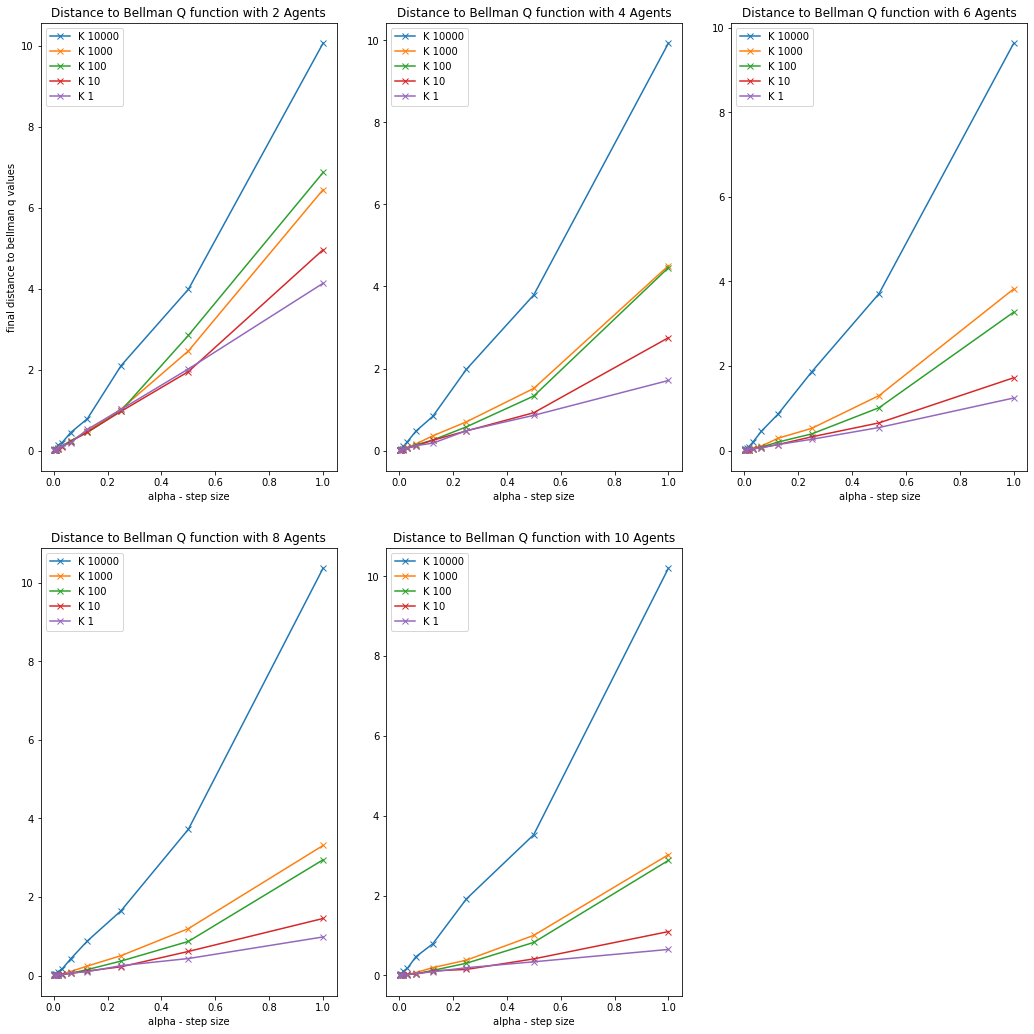

In [39]:
plt.clf()

for i in range(len(fedPs)):
    for syncBackups in syncBackupValues:
        fedP = fedPs[i]
        epsilon = 1
#         syncBackups = 1
        loadData(epsilon=epsilon, syncBackups=syncBackups)
        for placehold2 in [0]:
            plt.subplot(2, len(fedPs)//2 + 1, i+1)
            plt.tight_layout(pad=3)
            plotName = "Distance to Bellman Q function with " + str(fedP) + " Agents"

            plt.plot(alphas, np.array(diffsFed[fedP]) ** 2, marker="x", label="K " + str(syncBackups))

            plt.legend()
            plt.xlabel("alpha - step size")
            if i == 0:
                plt.ylabel("final distance to bellman q values")

            plt.title(plotName.replace("_", " "))
            # plt.ylim(0, 4)
#             plt.yscale('log', base=2)
#             plt.xscale('log', base=2)
            
plt.rcParams['figure.figsize'] = [20, 20]
plt.show()

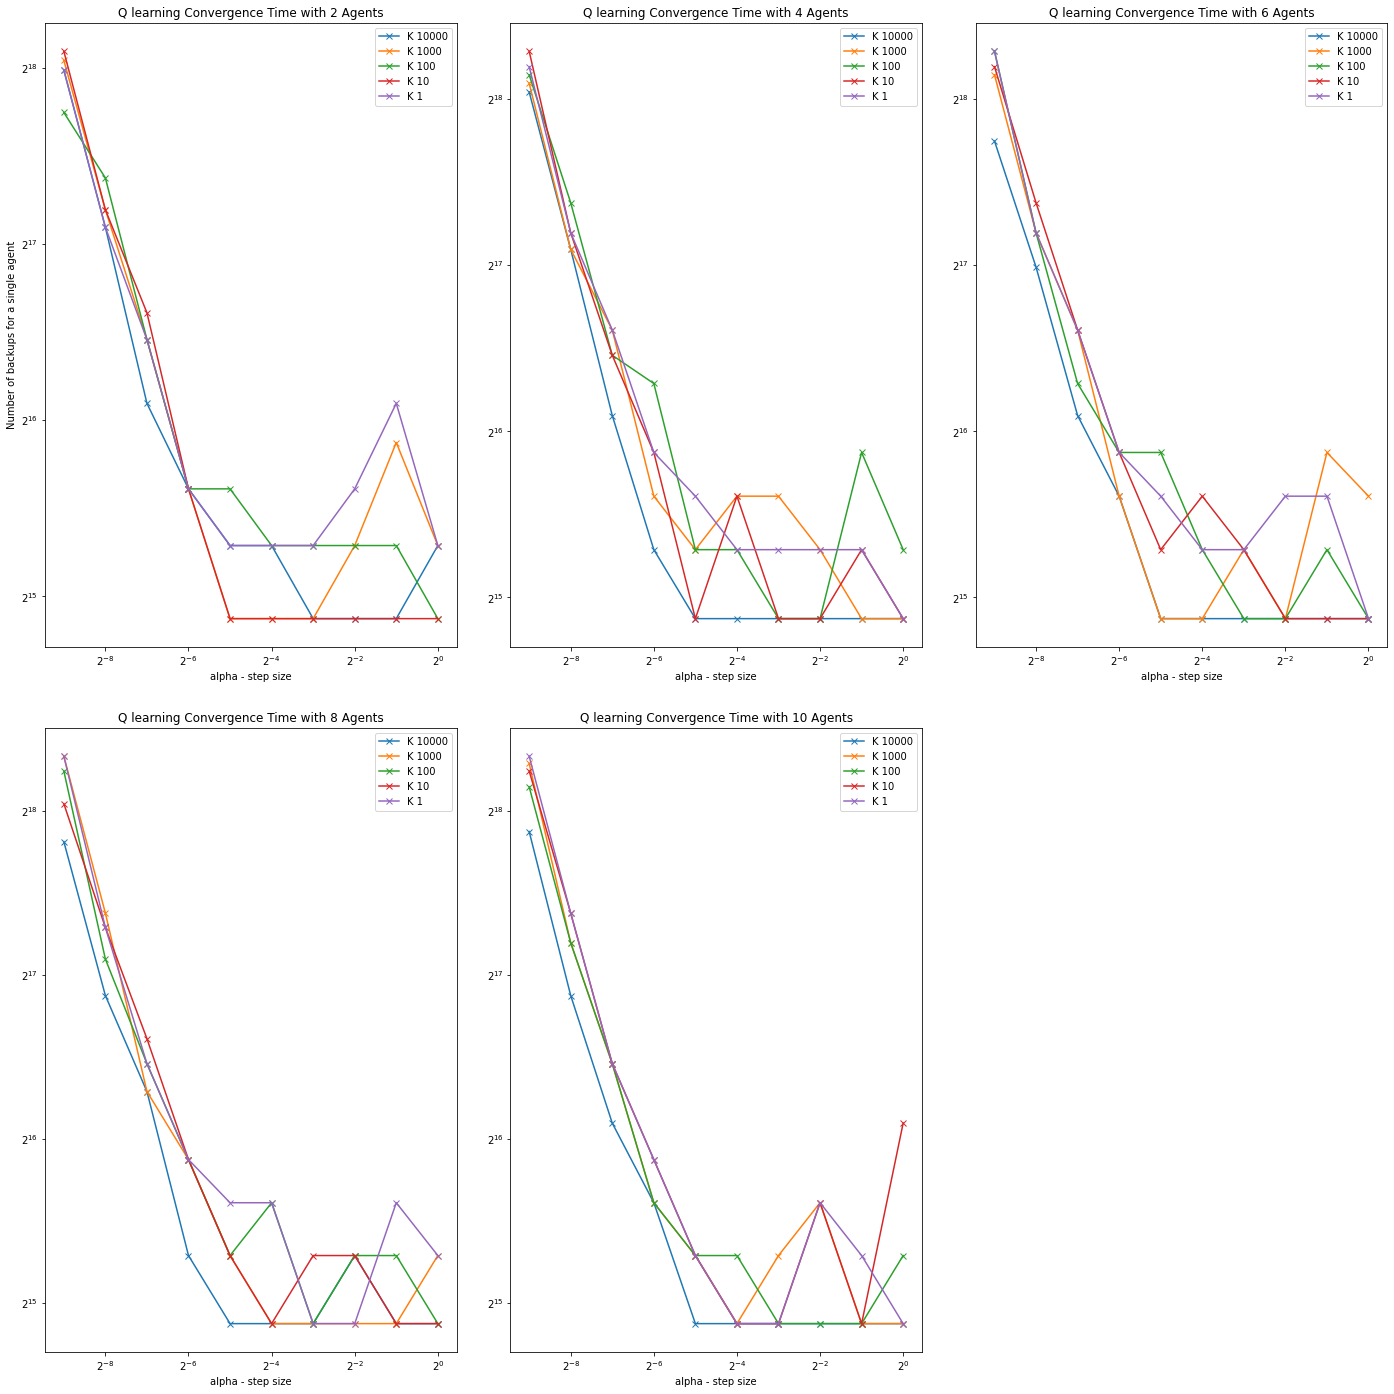

In [37]:
plt.clf()
for i in range(len(fedPs)):
    for syncBackups in syncBackupValues:
        fedP = fedPs[i]
        epsilon = 1
#         syncBackups = 1
        loadData(epsilon=epsilon, syncBackups=syncBackups)
        for placehold2 in [0]:
            plt.subplot(2, len(fedPs)//2 + 1, i+1)
            plt.tight_layout(pad=3)
            plotName = "Q learning Convergence Time with " + str(fedP) + " Agents"

            plt.plot(alphas, np.array(epsFed[fedP]) * 100, marker="x", label="K " + str(syncBackups))

            plt.legend()
            plt.xlabel("alpha - step size")
            if i == 0:
                plt.ylabel("Number of backups for a single agent")

            plt.title(plotName.replace("_", " "))
            # plt.ylim(0, 4)
            
            plt.yscale('log', base=2)
            plt.xscale('log', base=2)
            
plt.rcParams['figure.figsize'] = [15, 15]
plt.show()

In [38]:
# epsilon = 1
# loadData(epsilon=epsilon, syncBackups=1)
# plt.clf()
# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.scatter3D(np.log2(alphas), np.log2([1]*len(alphas)), np.log2(diffsSin), label="Single Agent")
# for fedP in fedPs:
#     ax.scatter3D(np.log2(alphas), np.log2([fedP]*len(alphas)), np.log2(diffsFed[fedP]), label=str(fedP) + " Agent")
# ax.set_xlabel("alpha - step size log2")
# ax.set_ylabel("p - Number of Agents log2")
# ax.set_zlabel("final distance to bellman q values log2")
# plotName = "Q learning Difference from Bellman with Eps " + str(epsilon)
# plt.title(plotName)
# plt.show()  